<a href="https://colab.research.google.com/github/ritusinha128/health-informatics-project/blob/main/chest_cancer/Chest_Cancer_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving Kaggle.json to Kaggle (3).json


{'Kaggle (3).json': b'{"username":"harshithasanjeev","key":"75dae23f53cb9eb626e75bc420c8f7e9"}'}

In [ ]:
from google.colab import files
files.upload()

Saving Kaggle.json to Kaggle (1).json


{'Kaggle (1).json': b'{"username":"harshithasanjeev","key":"75dae23f53cb9eb626e75bc420c8f7e9"}'}

In [2]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!cp Kaggle.json ~/.kaggle/kaggle.json

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d unaissait/curated-chest-xray-image-dataset-for-covid19

curated-chest-xray-image-dataset-for-covid19.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_file_path = '/content/curated-chest-xray-image-dataset-for-covid19.zip'
extraction_directory = '/content'

# Check if the extraction directory exists, create if it does not
if not os.path.exists(extraction_directory):
    os.makedirs(extraction_directory)

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

print(f'Files extracted to {extraction_directory}')

Files extracted to /content


In [7]:
import os
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt


from torch import nn
from typing import Any
from torch.backends import mps
from torchvision import models
from tqdm.notebook import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter


bar = "="
version = torch.__version__
writer = SummaryWriter('./logs')

if mps.is_available() :
    device = torch.device('mps')
elif torch.cuda.is_available() :
    device = torch.device('cuda')
else :
    device = torch.device('cpu')

print(f'{bar*10}Device INFO{bar*10}')
print(f'PyTorch Version :{version}')
print(f'Device :{device}')
print(bar*31)

==========Device INFO==========
PyTorch Version :2.2.1+cu121
Device :cuda


In [8]:
transformer = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.5),
    transforms.ColorJitter(saturation=0.5),
    transforms.ToTensor()
])

In [9]:
lable_name = ['Covid', 'Normal',  'Pneumonia Bacterial']#, 'Viral Pneumonia']
dataset = ImageFolder('../content/Curated X-Ray Dataset/', transform=transformer)
dataset.classes

['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']

In [10]:
COV_DIR = "/content/Curated X-Ray Dataset/COVID-19"
NORM_DIR = "/content/Curated X-Ray Dataset/Normal"
BAC_DIR = "/content/Curated X-Ray Dataset/Pneumonia-Bacterial"
#VIR_DIR = "/content/Curated X-Ray Dataset/Pneumonia-Viral"

In [11]:
folder = os.makedirs ('/kaggle/working/dataset', exist_ok=True)

In [12]:
directories = {
    'covid-19': "/content/Curated X-Ray Dataset/COVID-19",
    'Normal': "/content/Curated X-Ray Dataset/Normal",
    'bacterial': "/content/Curated X-Ray Dataset/Pneumonia-Bacterial",
    #'viral': "/content/Curated X-Ray Dataset/Pneumonia-Viral"
}


# Count the number of images in each directory
for class_name, directory in directories.items():
    num_images = len(os.listdir(directory))
    print(f"Number of images in {class_name} directory: {num_images}")

Number of images in covid-19 directory: 1281
Number of images in Normal directory: 3270
Number of images in bacterial directory: 3001


In [13]:
from sklearn.model_selection import train_test_split

data_train=[]
labels_train=[]
data_test=[]
labels_test=[]
data_val=[]
labels_val=[]

COVID_files = os.listdir(COV_DIR)
Normal_files = os.listdir(NORM_DIR)
Bacterial_files = os.listdir(BAC_DIR)
#Viral_files = os.listdir(VIR_DIR)

In [14]:
def wb(channel, perc = 0.05):
    mi, ma = (np.percentile(channel, perc), np.percentile(channel,100.0-perc))
    channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
    return channel

In [15]:
COVID_train_files, COVID_test_files = train_test_split(COVID_files, test_size=0.20, random_state=42)
COVID_train_files, COVID_val_files = train_test_split(COVID_train_files, test_size=0.20, random_state=42)

Normal_train_files, Normal_test_files = train_test_split(Normal_files, test_size=0.20, random_state=42)
Normal_train_files, Normal_val_files = train_test_split(Normal_train_files, test_size=0.20, random_state=42)

Bacterial_train_files, Bacterial_test_files = train_test_split(Bacterial_files, test_size=0.20, random_state=42)
Bacterial_train_files, Bacterial_val_files = train_test_split(Bacterial_train_files, test_size=0.20, random_state=42)

#Viral_train_files, Viral_test_files = train_test_split(Viral_files, test_size=0.20, random_state=42)
#Viral_train_files, Viral_val_files = train_test_split(Viral_train_files, test_size=0.20, random_state=42)

In [16]:
for a in COVID_train_files:
    image = cv2.imread(os.path.join(COV_DIR, a))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_train.append(image)
    labels_train.append(0)

for a in COVID_test_files:
    image = cv2.imread(os.path.join(COV_DIR, a))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_test.append(image)
    labels_test.append(0)

for a in COVID_val_files:
    image = cv2.imread(os.path.join(COV_DIR, a))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_val.append(image)
    labels_val.append(0)

In [17]:
for b in Normal_train_files:
    image = cv2.imread(os.path.join(NORM_DIR, b))
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_train.append(image)
    labels_train.append(1)

for b in Normal_test_files:
    image = cv2.imread(os.path.join(NORM_DIR, b))
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_test.append(image)
    labels_test.append(1)

for b in Normal_val_files:
    image = cv2.imread(os.path.join(NORM_DIR, b))
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_val.append(image)
    labels_val.append(1)

In [18]:
for c in Bacterial_train_files:
    image = cv2.imread(os.path.join(BAC_DIR, c))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_train.append(image)
    labels_train.append(2)

for c in Bacterial_test_files:
    image = cv2.imread(os.path.join(BAC_DIR, c))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_test.append(image)
    labels_test.append(2)

for c in Bacterial_val_files:
    image = cv2.imread(os.path.join(BAC_DIR, c))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_val.append(image)
    labels_val.append(2)

In [ ]:
for c in Viral_train_files:
    image = cv2.imread(os.path.join(VIR_DIR, c))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_train.append(image)
    labels_train.append(3)

for c in Viral_test_files:
    image = cv2.imread(os.path.join(VIR_DIR, c))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_test.append(image)
    labels_test.append(3)

for c in Viral_val_files:
    image = cv2.imread(os.path.join(VIR_DIR, c))
    # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    data_val.append(image)
    labels_val.append(3)

In [19]:
print("Number of images in train lists :")
print("COVID-19:", labels_train.count(0))
print("Normal:", labels_train.count(1))
print("Pneumonia-Bacterial:", labels_train.count(2))
#print("Pneumonia-Viral:", labels_train.count(3))

print("\n Number of images in test lists :")
print("COVID-19:", labels_test.count(0))
print("Normal:", labels_test.count(1))
print("Pneumonia-Bacterial:", labels_test.count(2))
#print("Pneumonia-Viral:", labels_test.count(3))

print("\n Number of images in validation lists :")
print("COVID-19:", labels_val.count(0))
print("Normal:", labels_val.count(1))
print("Pneumonia-Bacterial:", labels_val.count(2))
#print("Pneumonia-Viral:", labels_val.count(3))

Number of images in train lists :
COVID-19: 819
Normal: 2092
Pneumonia-Bacterial: 1920

 Number of images in test lists :
COVID-19: 257
Normal: 654
Pneumonia-Bacterial: 601

 Number of images in validation lists :
COVID-19: 205
Normal: 524
Pneumonia-Bacterial: 480


In [20]:
x_train = np.array (data_train)
y_train = np.array (labels_train)

x_test = np.array (data_test)
y_test = np.array (labels_test)

x_val = np.array (data_val)
y_val = np.array (labels_val)

In [21]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Check the shapes of the resulting sets
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("x_val shape:", x_val.shape)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_val shape:", y_val.shape)

x_train shape: (4831, 224, 224, 3)
x_test shape: (1512, 224, 224, 3)
x_val shape: (1209, 224, 224, 3)
y_train shape: (4831, 3)
y_test shape: (1512, 3)
y_val shape: (1209, 3)


In [26]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    horizontal_flip=True,
    fill_mode="nearest")

batch_size = 32
image_size = (224, 224)

train_dataset = datagen.flow(x_train,
                            y_train,
                             batch_size=batch_size,
                             shuffle=True)

test_dataset = datagen.flow(x_test,
                            y_test,
                            batch_size=batch_size,
                            shuffle=True)

validation_dataset = datagen.flow(x_val,
                                  y_val,
                                  batch_size=batch_size,
                                  shuffle=False)

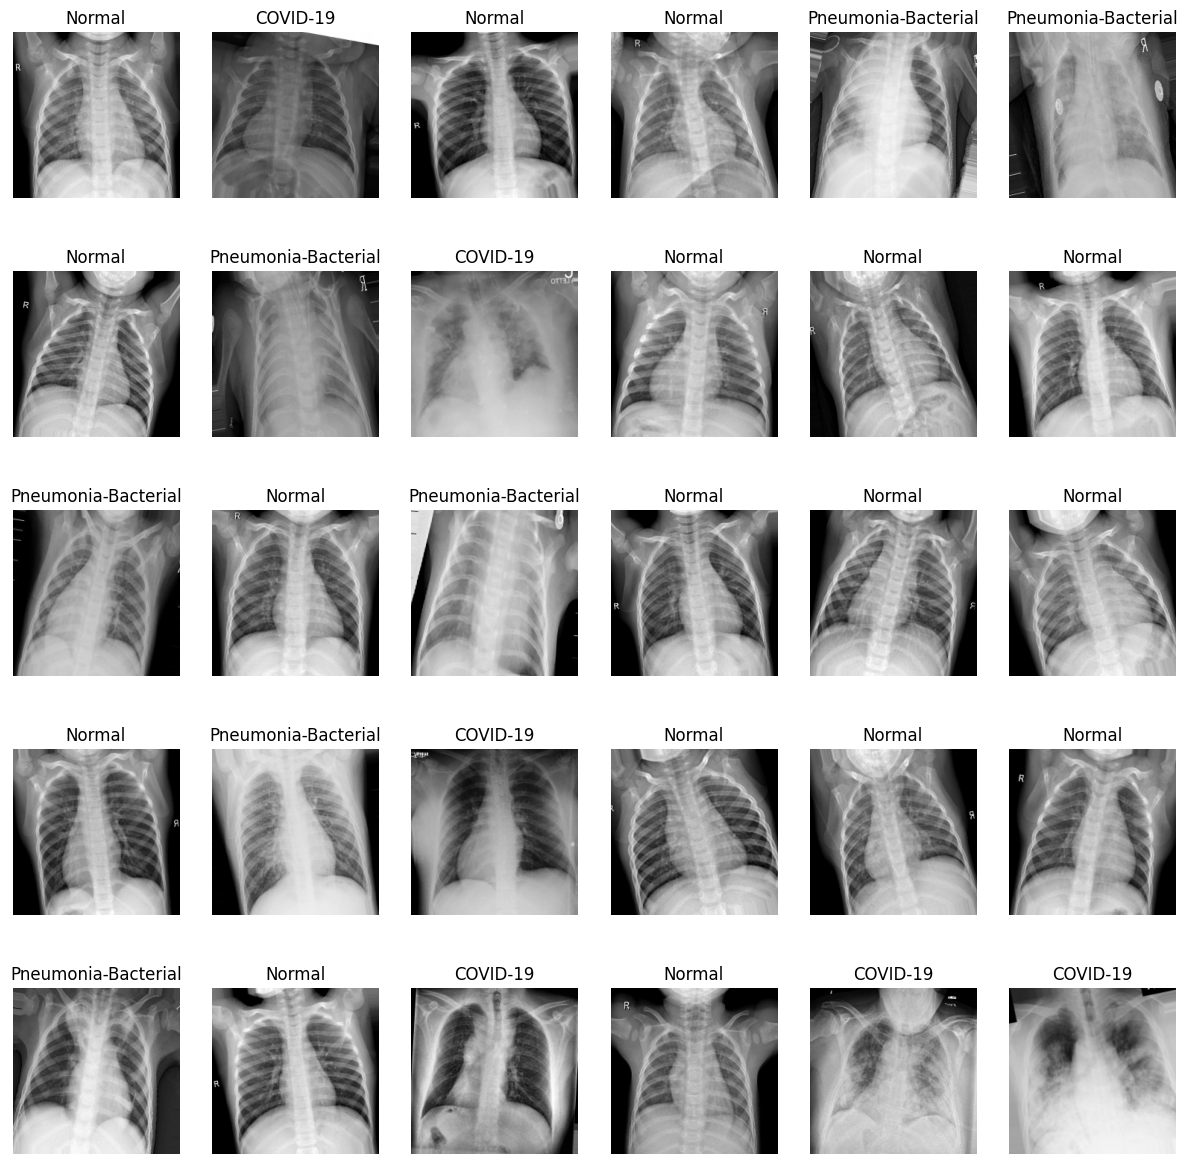

In [27]:
import matplotlib.pyplot as plt

# Get the first batch from the train dataset
batch_images, batch_labels = train_dataset.next()

# Define class names
class_names = ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']

# Plot the first 30 images
plt.figure(figsize=(15, 15))
for i in range(30):
    plt.subplot(5, 6, i + 1)
    plt.imshow(batch_images[i])
    plt.title(class_names[np.argmax(batch_labels[i])])
    plt.axis("off")

plt.show()

In [28]:
pip install torch torchvision

In [22]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [23]:
class MyModel(nn.Module):
    def __init__(self, num_classes=3):
        super(MyModel, self).__init__()
        vgg16_base = models.vgg16(pretrained=True)
        self.vgg16_features = vgg16_base.features
        for param in self.vgg16_features.parameters():
            param.requires_grad = False

        mobilenet_base = models.mobilenet_v2(pretrained=True)
        self.mobilenet_features = mobilenet_base.features
        for param in self.mobilenet_features.parameters():
            param.requires_grad = False

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()

        # Dynamically calculate input features to linear layer
        # Use temporary tensor to infer shape
        with torch.no_grad():
            x_temp = torch.zeros(1, 3, 224, 224)
            x1_temp = self.vgg16_features(x_temp)
            x1_temp = self.global_avg_pool(x1_temp)
            x1_temp = self.flatten(x1_temp)

            x2_temp = self.mobilenet_features(x_temp)
            x2_temp = self.global_avg_pool(x2_temp)
            x2_temp = self.flatten(x2_temp)

            total_features = x1_temp.shape[1] + x2_temp.shape[1]

        self.fc = nn.Sequential(
            nn.Linear(total_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x1 = self.vgg16_features(x)
        x1 = self.global_avg_pool(x1)
        x1 = self.flatten(x1)

        x2 = self.mobilenet_features(x)
        x2 = self.global_avg_pool(x2)
        x2 = self.flatten(x2)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x


In [24]:
from torch.utils.data import Dataset
import torch

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (numpy.ndarray): The image data in (num_samples, height, width, channels) format.
            labels (numpy.ndarray): The labels for the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label.argmax()  # Assuming labels are one-hot encoded and need to be converted to indices

# Define transformations including normalization and data augmentation
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert arrays to PIL images to use higher-level transforms
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [25]:
train_dataset = CustomDataset(x_train, y_train, transform=transform)
val_dataset = CustomDataset(x_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [29]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel(num_classes=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# For model summary
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [28]:
for epoch in range(50):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f'Epoch {epoch+1}, Train Loss: {running_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}')


Epoch 1, Train Loss: 0.4171014943141614, Val Loss: 0.1786564076319337
Epoch 2, Train Loss: 0.20047266148524173, Val Loss: 0.1686840609365486
Epoch 3, Train Loss: 0.19125333292693492, Val Loss: 0.10859156075227809
Epoch 4, Train Loss: 0.15576813221347846, Val Loss: 0.08893727350636925
Epoch 5, Train Loss: 0.15926808155209615, Val Loss: 0.08524607053320658
Epoch 6, Train Loss: 0.14843570847767373, Val Loss: 0.14836750302684346
Epoch 7, Train Loss: 0.12424160717425263, Val Loss: 0.10431886473854415
Epoch 8, Train Loss: 0.1436618139399894, Val Loss: 0.10687853338343925
Epoch 9, Train Loss: 0.13999824298681407, Val Loss: 0.09407029869525056
Epoch 10, Train Loss: 0.12299842870368666, Val Loss: 0.08391526762371589
Epoch 11, Train Loss: 0.12179859007233816, Val Loss: 0.12344350470965237
Epoch 12, Train Loss: 0.1262233969323732, Val Loss: 0.10394953502538173
Epoch 13, Train Loss: 0.10790295536562011, Val Loss: 0.07520771904627939
Epoch 14, Train Loss: 0.11591721372987261, Val Loss: 0.0827086351

In [30]:
import numpy as np

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(50):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')


Epoch 1, Train Loss: 0.4029, Train Acc: 0.8396, Val Loss: 0.1454, Val Acc: 0.9487
Epoch 2, Train Loss: 0.1978, Train Acc: 0.9348, Val Loss: 0.1659, Val Acc: 0.9371
Epoch 3, Train Loss: 0.1881, Train Acc: 0.9296, Val Loss: 0.1735, Val Acc: 0.9537
Epoch 4, Train Loss: 0.1857, Train Acc: 0.9352, Val Loss: 0.1170, Val Acc: 0.9644
Epoch 5, Train Loss: 0.1408, Train Acc: 0.9505, Val Loss: 0.1068, Val Acc: 0.9644
Epoch 6, Train Loss: 0.1482, Train Acc: 0.9491, Val Loss: 0.1047, Val Acc: 0.9644
Epoch 7, Train Loss: 0.1256, Train Acc: 0.9590, Val Loss: 0.0983, Val Acc: 0.9677
Epoch 8, Train Loss: 0.1467, Train Acc: 0.9454, Val Loss: 0.1208, Val Acc: 0.9595
Epoch 9, Train Loss: 0.1334, Train Acc: 0.9518, Val Loss: 0.1475, Val Acc: 0.9479
Epoch 10, Train Loss: 0.1147, Train Acc: 0.9590, Val Loss: 0.1121, Val Acc: 0.9628
Epoch 11, Train Loss: 0.1176, Train Acc: 0.9582, Val Loss: 0.0850, Val Acc: 0.9677
Epoch 12, Train Loss: 0.1164, Train Acc: 0.9588, Val Loss: 0.0764, Val Acc: 0.9727
Epoch 13, Tra

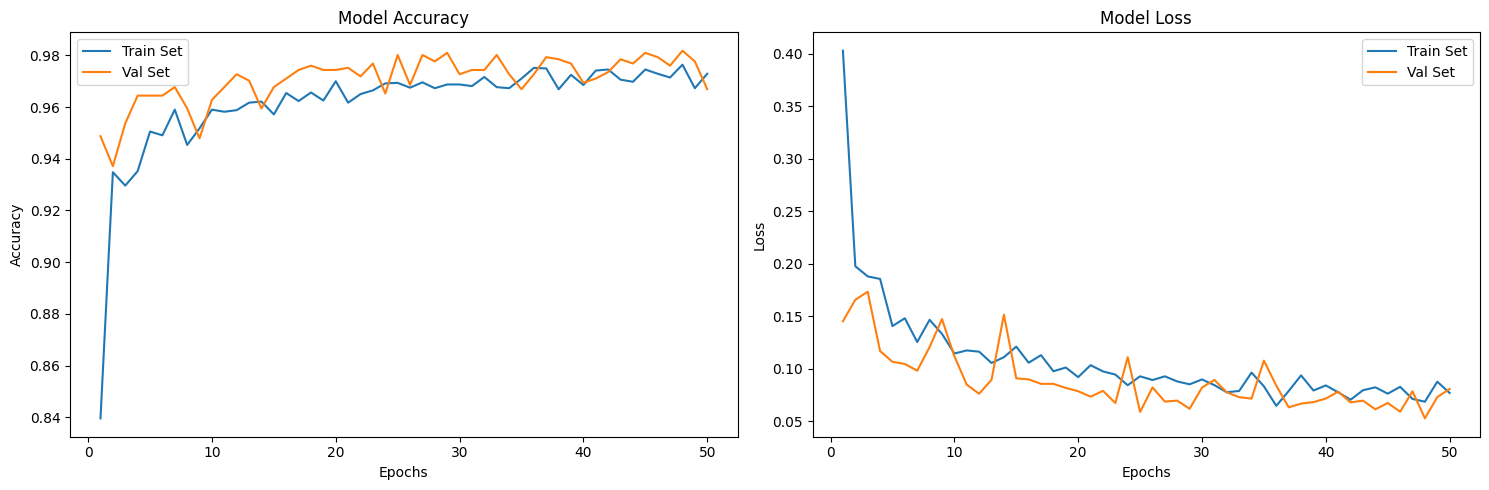

In [32]:
import matplotlib.pyplot as plt

# Assuming 'train_loss', 'val_loss', 'train_accuracy', and 'val_accuracy' are accumulated during the training process
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Set')
plt.plot(epochs_range, val_accuracies, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Set')
plt.plot(epochs_range, val_losses, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.tight_layout()
plt.show()


In [36]:
test_dataset = CustomDataset(x_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
accuracy = 0
total = 0
correct = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('\nTest Accuracy:', accuracy)



Test Accuracy: 0.9623015873015873


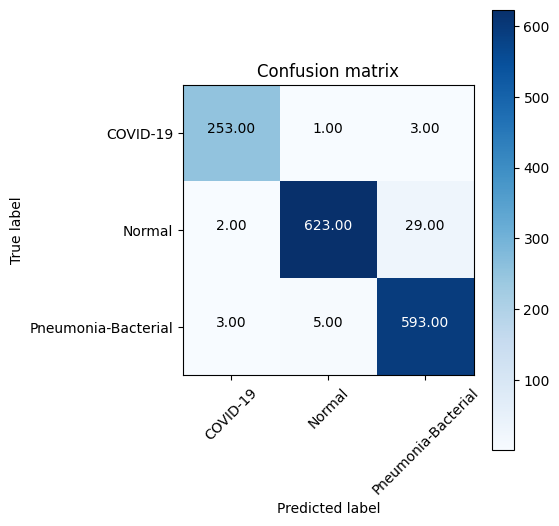

In [38]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

confusion_mtx = confusion_matrix(all_labels, all_preds)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    target_names = ['COVID-19', 'Normal', 'Pneumonia-Bacterial']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout(pad=3.0)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusion_mtx, classes=['COVID-19', 'Normal', 'Pneumonia-Bacterial'])


In [39]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=['COVID-19', 'Normal', 'Pneumonia-Bacterial']))


                     precision    recall  f1-score   support

           COVID-19       0.98      0.98      0.98       257
             Normal       0.99      0.95      0.97       654
Pneumonia-Bacterial       0.95      0.99      0.97       601

           accuracy                           0.97      1512
          macro avg       0.97      0.97      0.97      1512
       weighted avg       0.97      0.97      0.97      1512



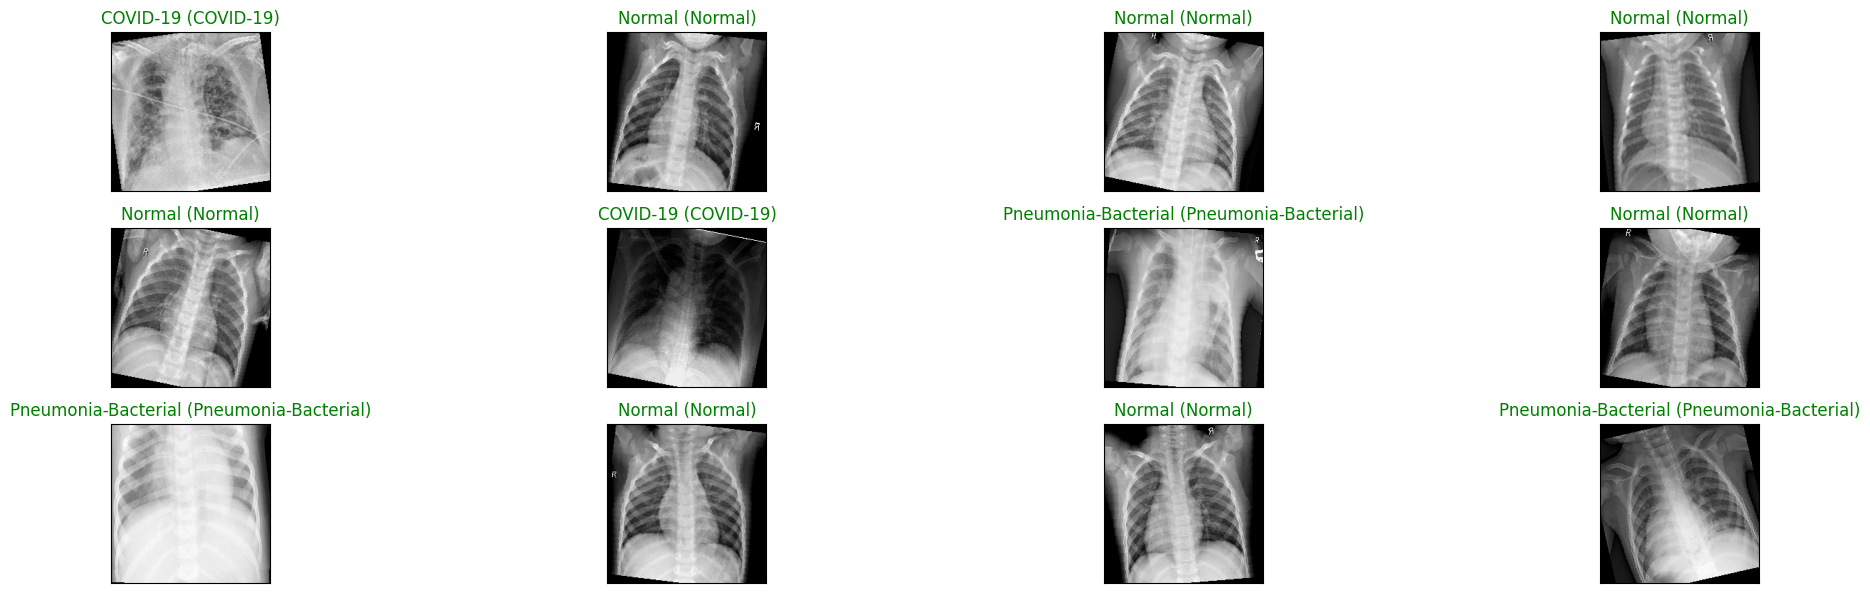

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Define label names for the classes
cxr_labels = ['COVID-19', 'Normal', 'Pneumonia-Bacterial']

# Set the model to evaluation mode
model.eval()

# Create a figure to display the images and predictions
fig = plt.figure(figsize=(20, 8))
with torch.no_grad():
    for i, idx in enumerate(np.random.choice(len(test_dataset), size=12, replace=False)):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        img, true_label = test_dataset[idx]
        img = img.unsqueeze(0).to(device)
        outputs = model(img)
        _, pred = torch.max(outputs, 1)
        pred = pred.cpu().numpy()[0]

        # Assuming img is a tensor that needs to be converted for display
        img = img.cpu().squeeze().permute(1, 2, 0)  # Change CxHxW to HxWxC if necessary
        # If normalization is applied, you might need to reverse it for displaying
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img.numpy() + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        pred_label = pred
        true_label = true_label.item()
        ax.set_title(f"{cxr_labels[pred_label]} ({cxr_labels[true_label]})",
                     color=("green" if pred_label == true_label else "red"))

plt.tight_layout()
plt.show()
